## Fake News Detection

### **Tujuan**

Dampak yang ditimbulkan adanya berita hoax akan sangat luar biasa antara lain, berupa dampak sosial,ekonomi, politik, keamanan dan yang lebih besar adalah bisa mengancam keutuhan negara. Penyebaran berita hoax sering terjadi di media sosial dan mempengaruhi pola pikir masyarakat.

*Fake news is a modern problem which requires modern solutions.*

### **Dataset**
Sumber dataset : https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

### **Import**

In [2]:
import pandas as pd

#Visualisasi
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from string import punctuation
import spacy

#Preprocessing
from nltk.corpus import stopwords
import nltk

### **Load & EDA**

In [3]:
trueNews = pd.read_csv("Datasets/True.csv")
fakeNews = pd.read_csv("Datasets/Fake.csv")

#Berikan label untuk tiap data
trueNews['label'] = 1
fakeNews['label'] = 0

df = pd.concat([fakeNews, trueNews], axis =0) #Gabungkan data

df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


#### Shape tiap data

In [4]:
print(f'Dimensi data Fake-News : {fakeNews.shape}')
print(f'Dimensi data True-News : {trueNews.shape}')
print(f'Dimensi data Gabungan  : {df.shape}')

Dimensi data Fake-News : (23481, 5)
Dimensi data True-News : (21417, 5)
Dimensi data Gabungan  : (44898, 5)


#### Inspect kolom

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


#### Inspect data kategorikal

In [6]:
cat = ['subject','label']

for i in cat:
    print(df[i].value_counts())
    print("")

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

0    23481
1    21417
Name: label, dtype: int64



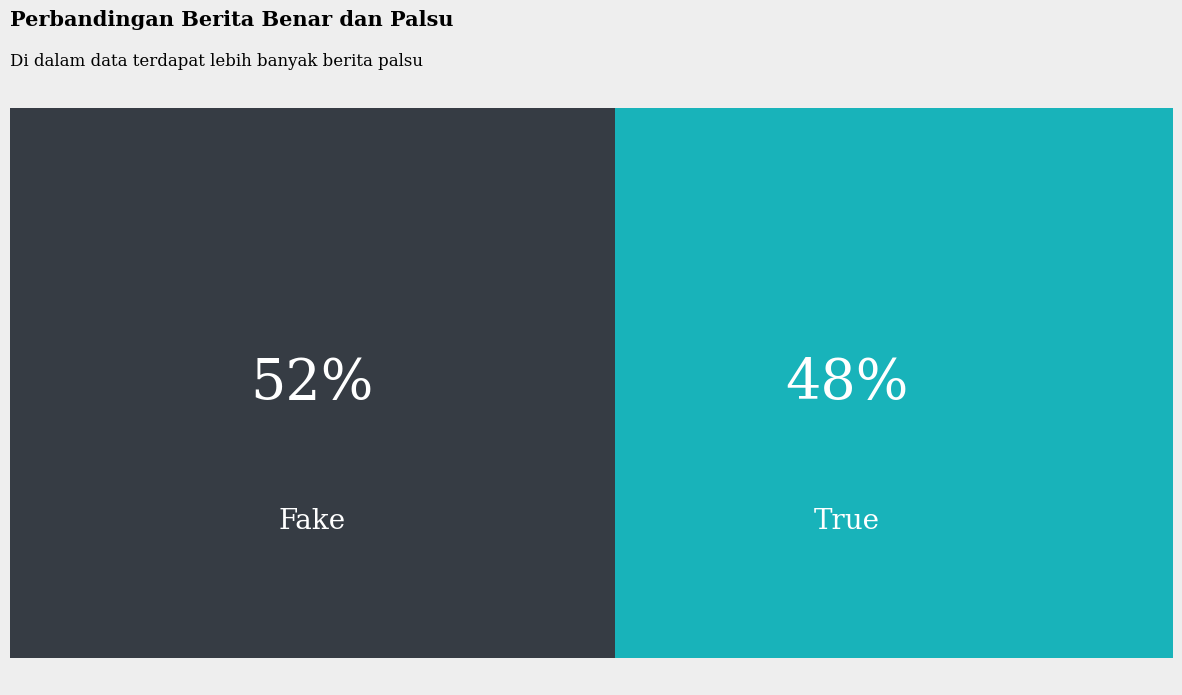

In [7]:
x = df.groupby('label')['label'].count()
y = len(df)


r=((x/y)).round(2)
status_ratio = pd.DataFrame(r).T
status_ratio.columns = ["Fake", "True"]

fig, ax = plt.subplots(1,1,figsize=(15, 8),dpi = 100)

fig.patch.set_facecolor('#EEEEEE')

ax.set_facecolor('#EEEEEE')

ax.barh(status_ratio.index, status_ratio['Fake'], 
        color='#222831', alpha=0.9, label='Fake')
ax.barh(status_ratio.index, status_ratio['True'], left=status_ratio['Fake'], 
        color='#00ADB5', alpha=0.9, label='True')


for i in status_ratio.index:
    ax.annotate(f"{int(status_ratio['Fake'][i]*100)}%", 
                   xy=(status_ratio['Fake'][i]/2, i),
                   va = 'center', ha='center',fontsize=40, fontweight='light', fontfamily='serif',
                   color='white')

    ax.annotate("Fake", 
                   xy=(status_ratio['Fake'][i]/2, -0.20),
                   va = 'center', ha='center',fontsize=20, fontweight='light', fontfamily='serif',color='white')

for i in status_ratio.index:
    ax.annotate(f"{int(status_ratio['True'][i]*100)}%", 
                   xy=(status_ratio['True'][i]+status_ratio['True'][i]/2, i),
                   va = 'center', ha='center',fontsize=40, fontweight='light', fontfamily='serif',
                   color='white')
    ax.annotate("True", 
                   xy=(status_ratio['True'][i]+status_ratio['True'][i]/2, -0.20),
                   va = 'center', ha='center',fontsize=20, fontweight='light', fontfamily='serif',
                   color='white')

ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticks([])

# Title & Subtitle
fig.text(0.125,0.95,'Perbandingan Berita Benar dan Palsu', fontfamily='serif',fontsize=15, fontweight='bold')
fig.text(0.125,0.90,'Di dalam data terdapat lebih banyak berita palsu',fontfamily='serif',fontsize=12)  

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)

#### Check Null Value

In [8]:
df.isna().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

Tidak terdapat nilai *null* didalam data

#### Wordclouds

In [9]:
TrueWords = trueNews['text'].tolist()
FalseWords = fakeNews['text'].tolist()

#Hilangkan stopwords
stopwords = set(stopwords.words('english'))
TrueWords = [word for word in TrueWords if not word in stopwords]
FalseWords = [word for word in FalseWords if not word in stopwords]

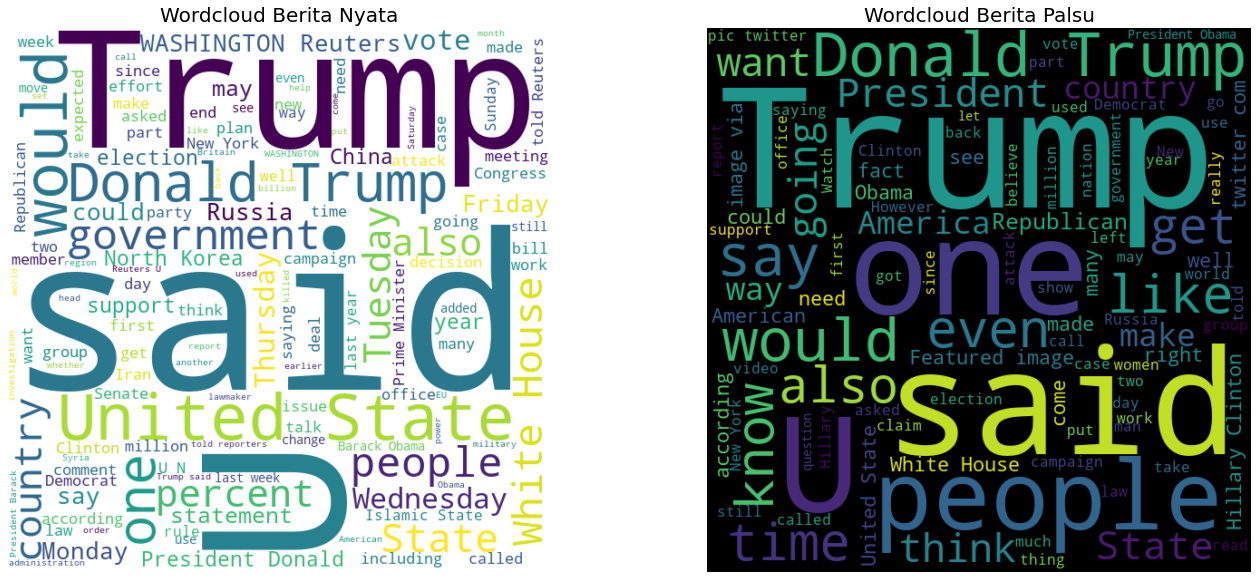

In [10]:
#buat word cloud
Truewordcloud = WordCloud(width = 600, height = 600, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(str(TrueWords))


Falsewordcloud = WordCloud(width = 600, height = 600, 
                stopwords = stopwords,
                max_words=100,
                min_font_size = 10).generate(str(FalseWords))  
  

#Plot wordcloud             
plt.figure(figsize = (23, 10), facecolor = None)

#Wordcloud Berita Nyata
plt.subplot(1,2,1)
plt.title("Wordcloud Berita Nyata",fontsize=20)
plt.imshow(Truewordcloud, interpolation='bilinear') 
plt.axis("off") 

#Wordcloud Berita Palsu
plt.subplot(1,2,2)
plt.title("Wordcloud Berita Palsu",fontsize=20)
plt.imshow(Falsewordcloud, interpolation='bilinear') 
plt.axis("off") 
  
plt.show()

Dapat dilihat bahwa baik berita palsu atau asli didominasi dengan jenis berita yang berbau politik

### Counter with bag-of-words

In [19]:
# Buat list dari semua kata yang ada di dataframe
count_TrueWord = [word for line in trueNews['text'] for word in line.split()]

# Ubah tiap kata menjadi huruf kecil
count_TrueWord = [i.lower() for i in count_TrueWord]

# Hapus stopwords dan kata hubung
count_TrueWord = [word for word in count_TrueWord if word not in stopwords and word not in punctuation]

count_TrueWord = Counter(count_TrueWord)
count_TrueWord  = count_TrueWord.most_common(10)

In [20]:
for words,counts in count_TrueWord:
    print(words,counts)

said 72035
u.s. 38276
trump 36485
would 31361
president 23399
said. 21583
(reuters) 21239
new 16578
also 15870
state 15608


In [26]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
# Create a list of document for spacy
doc_list = [nlp(doc) for doc in trueNews['text']]

# Remove stopwords and punctuation from the documents
no_stop_punct = [[token.text for token in doc if not token.is_stop and not token.is_punct] for doc in doc_list]


In [49]:
word_counter_true = Counter()
word_counter_false = Counter()

for row in trueNews['text']:
    doc = nlp(row)
    # Remove stopwords and punctuation
    words = [token.text for token in doc if not token.is_stop and not token.is_punct]
    # Select all the entities
    entities = [ent.text for ent in doc.ents if not ent.text.isspace() and ent.text != ' ']
    # Update the counter with new words
    word_counter_true.update(words + entities)


for row in fakeNews['text']:
    doc = nlp(row)
    # Remove stopwords and punctuation
    words = [token.text for token in doc if not token.is_stop and not token.is_punct]
    # Select all the entities
    entities = [ent.text for ent in doc.ents if not ent.text.isspace() and ent.text != ' ']
    # Update the counter with new words
    word_counter_false.update(words + entities)

In [47]:
word_counter = Counter()

word_counter = Counter()


doc = nlp("I love very much indonesia cat's ")
# Remove stopwords and punctuation
words = [token.text for token in doc if not token.is_stop and not token.is_punct]
# Select all the entities
entities = [ent.text for ent in doc.ents if not ent.text.isspace()]
# Update the counter with new words
word_counter.update(words + entities)

print(word_counter.most_common(10))
    
    

# Print the top 10 words
print(word_counter.most_common(10))
    

[('indonesia', 2), ('love', 1), ('cat', 1)]
[('indonesia', 2), ('love', 1), ('cat', 1)]


In [42]:
print(word_counter.most_common(10))

[(' ', 112255), ('said', 99043), ('Trump', 85634), ('U.S.', 70164), ('Reuters', 57041), ('s', 44725), ('Republican', 31108), ('House', 18898), ('President', 18574), ('government', 18144)]
